# Visualize competitive qpAdm Models

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-16-163.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [2]:
###################################################
###################################################
### Define Plot functions

def fig_admix(axes=[], res=[], p_vals=[], target_pops=[], 
              source_pops=[], figsize=(12,8), 
              save_path="", lw=2,
              pval_lim=[1e-6,1.0], stds=[], 
              l_pos = (1, 0.5), fs = 12, bw = 0.85, 
              c=[], ec = "white", show=False,
              height_ratios=[1, 8],
              rotation=90, legend=True):
    """Plot a Figure of the admixture coefficients.
    axes: 2 axis where to plot Fractions and p-Values onto
    res: nxk Array of Results
    p_vals: Array of p-Vals [n]
    target_pops: String Array of Target Pops [n]
    source_pops: String Array of Source Pops [k]
    stds: Standard Errors. If none are given do not plot them
    l_pos: Where to place the Legend.
    lw: Linewidth of bar"""
    # Create Pandas Dataframe for Plot
    #pd.DataFrame(data=target_pops, index=r, columns=source_pops)
    
    ### Define Axes if not given
    if len(axes)==0:
        fig, axes = plt.subplots(nrows=2, ncols=1,
                                 gridspec_kw={'height_ratios': height_ratios}, 
                                 figsize=figsize)
    ax0, ax1 = axes
    
    # Plot Parameters
    r = np.arange(len(target_pops))
    barWidth = bw
    if len(c)==0:
        c=["DeepPink", "MediumBlue", "purple", "yellowgreen", "gold"]
    
    for i, s in reversed(list(enumerate(source_pops))): # From last to first (For Legend)
        s = source_pops[i]
        b = np.sum(res[:,:i], axis=1)
        ax1.bar(r, res[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=s, alpha=0.9)
        
        if len(stds)>0: # Plot some standard deviations.
            ax1.errorbar(r, b+res[:,i], yerr=stds[:,i], fmt='none', linewidth=lw, color="k")
    
    ### Add the Model not viable bars:
    su = np.sum(res, axis=1)
    sum0ids = np.where(su==0)[0]
    
    for i in sum0ids:
        ax1.bar(i, 1, color="lightgray", edgecolor='white', width=barWidth, alpha=0.9)
     
    ################
    # Custom x axis
    ax1.set_xticks(r)
    ax1.set_xticklabels(target_pops, fontsize=fs, rotation=rotation)

    # Add a legend
    #l1 = ax1.legend(loc=l_pos, bbox_to_anchor=(1, 0.5), ncol=1, fontsize=fs)
    if legend:
        l1 = ax1.legend(bbox_to_anchor=l_pos, ncol=1, fontsize=fs)
        l1.set_title('Sources: ', prop={'size':fs})
    
    ax1.set_ylabel("Fraction Ancestry", fontsize=fs*1.5)
    ax1.set_ylim([0,1])
    ax1.set_xlim([-0.6, len(target_pops)-0.4])
    
    ax0.set_yscale("log")
    ax0.set_ylim(pval_lim)
    ax0.bar(r, p_vals, color="grey", width=barWidth, alpha=0.8, zorder=1)
    ax0.axhline(y=0.05, color='r', zorder=0)
    ax0.set_ylabel("p-Val", fontsize=fs)
    ax0.set_xlim([-0.6,len(target_pops)-0.4])
    ax0.set_xticks([])
    
    # Adjust position of subplots
    #plt.subplots_adjust(left=0, bottom=0.05, right=None,
    #            wspace=0, hspace=0.06)
    
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    
    if show:
        plt.show()
        
def plot_qpadm(dir_path, test_pops, save_path="", l_pos = (0.4, 1.15), 
               best=True, figsize=(12,8), bw = 0.85, lw=2,
               height_ratios = [1,8],
               c=[], ec="white", fs=10, pval_lim = [1e-3,1],
               latex=False, dataframe=False):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, 
    True use the best p-Value, 
    else use the old (first feasible)"""
    admix_coeffs = []
    p_vals = []
    pops_t = [] 
    stds = []
    pr = False # Print the statistics

    #for filename in os.listdir(dir_path):
    for f in test_pops:
        full_path = dir_path + str(f) + ".log" # Other "outputMycSicily_"
        res, p_val_ls, pops, std = load_qp_adm(full_path)

        pops_t.append(pops[0])
        
        if best == 0:
            i = give_admix0(res)   # Give the first result (if feasible)
            
        elif best == True:
            i = give_admix_index_best(res, p_val_ls) # Give the best feasible p-Value
        
        else:
            i = give_admix_index(res)
            
        #### Handle Not fitting Models  
        if np.isnan(i): # In Case no valid admixture:
            new_res = np.zeros(np.shape(res)[1]) # Not Plot anything
            std = np.zeros(np.shape(res)[1])     # Not Plot anything
            new_p = -1 # For Sorting
        
        else:
            new_res = res[i,:]
            new_p = p_val_ls[i]
        
        admix_coeffs.append(new_res)
        p_vals.append(new_p)
        stds.append(std)

        if pr == True:
            print("Population: %s" % f)
            print(res[i,:])
            print(std)
            print(p_val_ls[i])

    admix_coeffs, stds = np.array(admix_coeffs), np.array(stds)
    source_pops = pops[1:]
    
    fig_admix(res=admix_coeffs, 
              p_vals=p_vals, 
              target_pops=pops_t, 
              source_pops=source_pops, 
              pval_lim=pval_lim, 
              stds=stds, save_path = save_path, 
              l_pos = l_pos, lw=lw,
              height_ratios=height_ratios,
              fs=fs, figsize=figsize, 
              bw = bw, c=c, ec = ec)
    
    if latex:
        source_pops = [([t] + pops[1:]) for t in pops_t]
        create_latex_lines(source_pops, admix_coeffs, stds, 
                           p_vals, na = "-", rp = "A15")
        
    if dataframe:
        source_pops = np.array([([t] + pops[1:]) for t in pops_t])
        df = create_admix_df(source_pops, admix_coeffs, stds, p_vals)
        return(df)
    
    
def plot_qpadm_split(dfs, sources=[], figsize=(12,8), labels=[],
                     bw = 0.85, lw=2,
                     c=[], ec="white", fs=10, 
                     height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                     pval_lim = [1e-3, 1], pr=False, save_path="", 
                     leg_pos=1,legend=True, l_pos=(1, 0.5)):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, True use the best p-Value, 
    else use the old (first feasible)
    test_pops: List of lists: Will be split up into subdataframes
    pr: whether to print output"""
    
    ### Prepare the Full Figure Layout
    fig = plt.figure(figsize=figsize)
    
    width_ratios = list(map(len, dfs))
    gs = gridspec.GridSpec(2, len(dfs), 
                           width_ratios = width_ratios, 
                           height_ratios = height_ratios, 
                           figure = fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    ### Iterate over all Populations
    k = len(sources)
    
    for j, df in enumerate(dfs):   
        ######################
        ### Load the Data
        admix_coeffs = df[[f"f{i}" for i in range(1,k+1)]].values
        stds = df[[f"std{i}" for i in range(1,k+1)]].values
        p_vals = df["p"].values
        pops_t = df["t"].values 
        
        ######################
        ### Do the actual Plot
        ax_adm = fig.add_subplot(gs[0, j])
        ax_p = fig.add_subplot(gs[1, j])
        
        if j>0:
            legend=False
            
        fig_admix(axes=[ax_adm, ax_p], res=admix_coeffs, 
                  p_vals=p_vals, target_pops=pops_t, 
                  source_pops=sources, pval_lim=pval_lim, 
                  stds=stds, save_path = "", 
                  lw=lw, fs=fs, figsize=figsize, 
                  bw = bw, c=c, ec = ec, show=False,
                  legend=legend, l_pos = l_pos)
        
        ### Turn off the Labels for all but first plot
        if j>0:
            for ax in [ax_p, ax_adm]:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                
        if len(labels)>0:
                ax_adm.set_title(labels[j], fontsize=fs)
            
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', 
                    pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    plt.show()
    
### Helper Function
def set_feasible_df(df, sources=5):
    """Set Feasible Models"""
    
    fs = [f"f{i}" for i in range(1,sources+1)]

    idx_if = np.nanmin(df[fs], axis=1) < 0
    df["fs"] = True
    df.loc[idx_if, "fs"] = False
    
    print(f"Set {np.sum(idx_if)}/{len(idx_if)} infeasible models")
    return df

def get_spec_model(df, sources=[], tot_sources=5, 
                   drop=True, output=True):
    """Get specific model for dataframe df.
    Return dataframe with this model."""
    k = len(sources)
    found = np.ones(len(df), dtype="bool")
    for i in range(1,k+1):
        idx = df[f"s{i}"].isin(sources)
        found = found & idx
    for i in range(k+1, tot_sources+1): 
        idx = df[f"s{i}"].isnull()
        found = found & idx
        
    if output: 
        print(f"Found {np.sum(found)} fitting rows.")
    dft = df[found]
    
    ### Drop Unnecessary Labels
    if drop:
        for i in range(k+1, tot_sources+1):
            dft = dft.drop(columns=[f"s{i}", f"f{i}", f"std{i}"])
    
    return dft.reset_index(drop=True).copy()

def df_excl_source(df, exclude=[], tot_sources=5, 
                     output=True):
    """Return dataframe with specific sources excluded."""
    k = len(sources)
    
    found = np.ones(len(df), dtype="bool")
    for i in range(1, tot_sources+1):
        idx = df[f"s{i}"].isin(exclude)
        found = found & ~idx
        
    if output: 
        print(f"Found {np.sum(found)}/{len(found)} models without {exclude}.")
    dft = df[found]
    return dft.reset_index(drop=True).copy()   

def get_individual_models(df, min_p=0.01, feasible=True, best_p=False):
    """Get Dataframe with rows of best Indivdidual Model
    (lowest number of sources, highest p Value).
    best_p: Whether to pick model with best p-Value"""
    #df = df.sort_values(by=["p", "n"], ascending=[False, True])
    dft = df.copy()
    
    if feasible:
        dft = dft[dft["fs"]==True]
    
    ### Simply extract the best feasible Model
    if best_p:
        dft["n"]=0 # 
    else:
        dft.loc[(dft["p"]< min_p), "n"] = 100
           
    dft = dft.sort_values(by=["n", "p"], ascending=[True, False])
    idx_dup = dft["t"].duplicated()
    dft = dft[~idx_dup]
    return dft.reset_index(drop=True).copy()

def split_up_res_df(df1, dfq):
    """Split up individual qpAdm result
    dataframe into subdataframes according to
    dfq (matching on loc and containing clst)"""
    dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")

    dfs = []
    for index, row in dfq.iterrows():
        idx = (df1["loc"] == row["loc"]) & (df1["clst"].str.contains(row["clst"]))
        if np.sum(idx)==0:
            l = row["loc"]
            print(f" {l}: No samples found.")
            #continue
        dfs.append(df1[idx])
    ls = list(map(len, dfs))
    #assert(np.min(ls)>0)
    return dfs

def get_dfs_from_dfq(df, dfq, labels=[], min_p=0):
    """Procude list of dataframes with matching
    Indivdiuals"""
    dfs = []
    for l in labels:
        ### Get all matching Locations
        idx = dfq["label_qpadm"] == l
        locs = dfq.loc[idx, "loc"].values
        
        dft = df[df["loc"].isin(locs)]
        dft  = dft[dft["p"]>min_p]
        dfs.append(dft)
    assert(np.min(list(map(len,dfs)))>0)
    return dfs

### General Loading

In [9]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_dist.tsv", sep="\t")
df = set_feasible_df(df, sources=6)
df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 6942/12159 infeasible models


# Plot Split Up by Population [for paper]

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


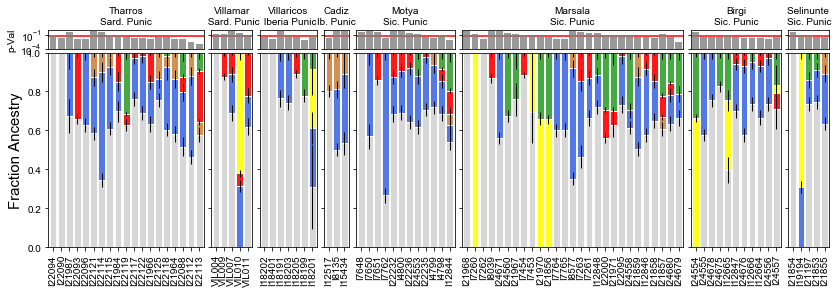

In [6]:
df1 = get_individual_models(df, min_p=0.01, feasible=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

### Plot Reference Populations

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


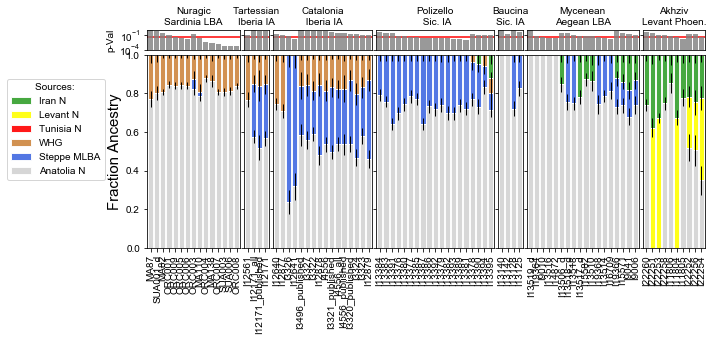

In [7]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=False)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(10,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

# Best p-Value

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


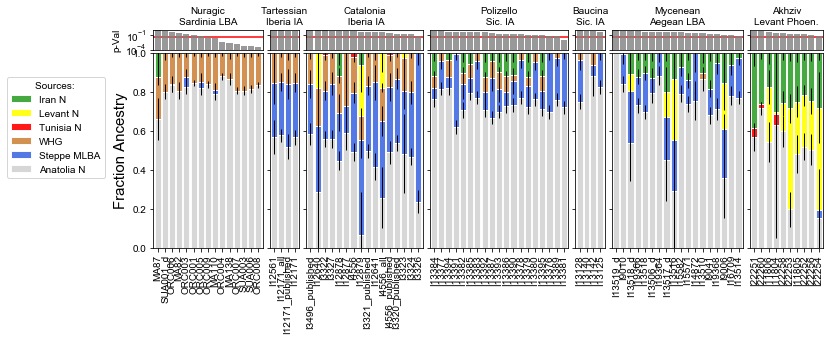

In [40]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(12,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

In [ ]:
df1["clst"].value_counts()

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


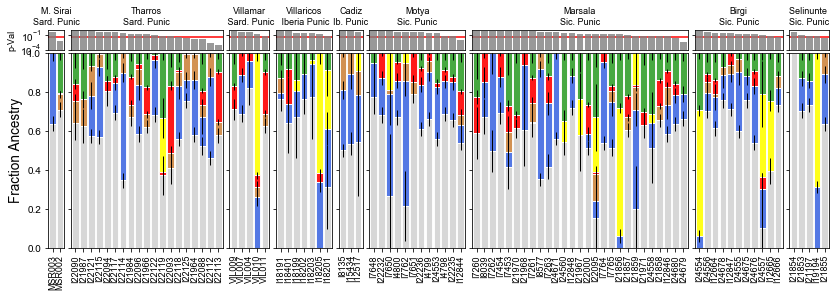

In [38]:
df1 = get_individual_models(df, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

# Best Model with Steppe as outgroup

Found 5983/12159 models without ['Steppe_MLBA'].
Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


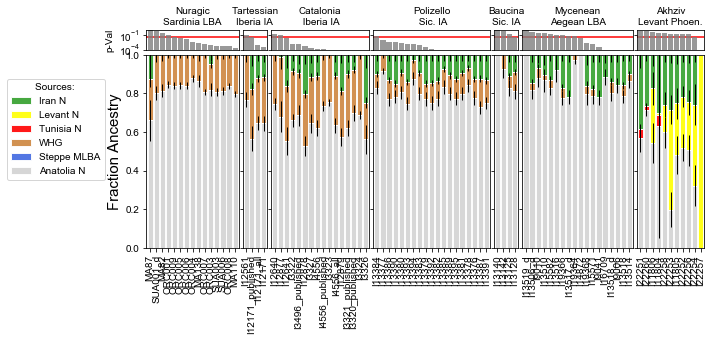

In [32]:
dft = df_excl_source(df, exclude=["Steppe_MLBA"], tot_sources=5, output=True)
df1 = get_individual_models(dft, min_p=0.01, feasible=True, best_p=True)


print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(10,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

Found 5983/12159 models without ['Steppe_MLBA'].
Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


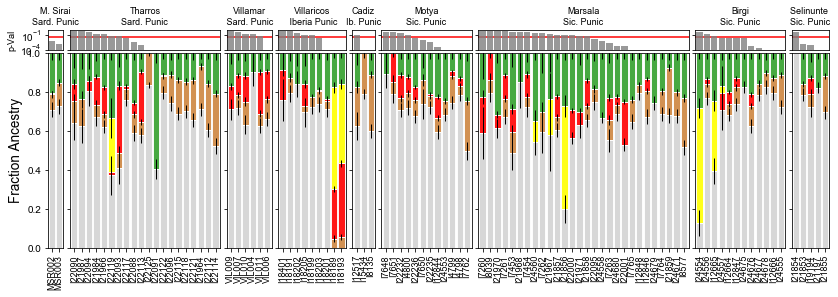

In [31]:
dft = df_excl_source(df, exclude=["Steppe_MLBA"], tot_sources=6, output=True)
df1 = get_individual_models(dft, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

# Use Algerian IA as North African Source

In [24]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_distAlgIA.tsv", sep="\t")
df = set_feasible_df(df, sources=6)
df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"
df["t"] = df["t"].str.replace("_published", "")

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 6897/12096 infeasible models


Loaded 190 individual best qpAdm models.
Merged to 190 Individuals with all data
Filtered to 149 Individuals with 100k SNPs


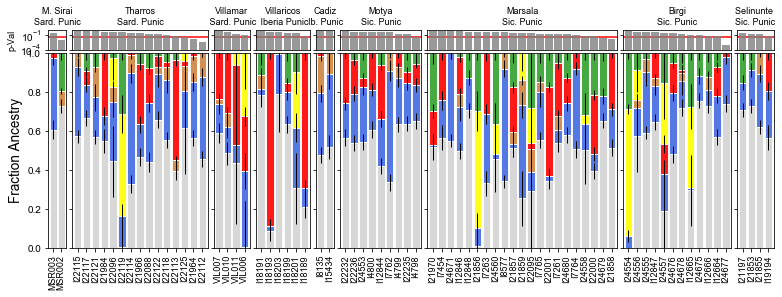

In [37]:
df1 = get_individual_models(df, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")
df1 = df1[df1["n_cov_snp"]>1e5]
print(f"Filtered to {len(df1)} Individuals with 100k SNPs")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(13, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

Loaded 190 individual best qpAdm models.
Merged to 190 Individuals with all data
Filtered to 149 Individuals with 100k SNPs


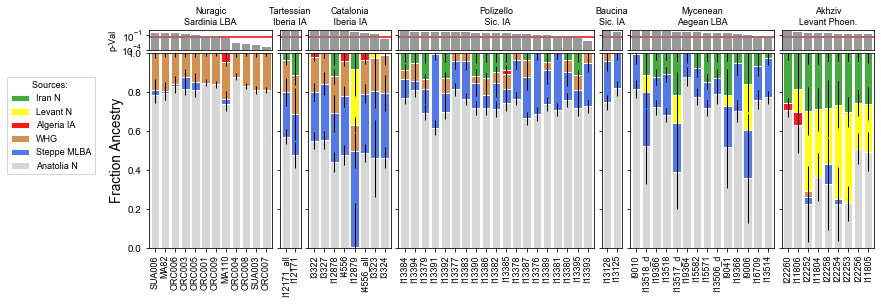

In [36]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")
df1 = df1[df1["n_cov_snp"]>1e5]
print(f"Filtered to {len(df1)} Individuals with 100k SNPs")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Algeria IA", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(13,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

## Visualize North African Admixture

# Area 51

In [14]:
df1

,t,p,n,s1,s2,s3,s4,s5,s6,f1,...,std5,std6,fs,iid,loc,clst,n_cov_snp,age,lat,lon
0,I13519_d,8.971119e-01,1,Anatolia_N,0,0,0,0,0,1.000,...,0.000,0.000,True,I13519_d,"Pylos, Palace of Nestor",Greece_BA_Mycenaean,24370.0,3275.0,37.026797,21.694586
1,I13140,8.821915e-01,1,Anatolia_N,0,0,0,0,0,1.000,...,0.000,0.000,True,I13140,"Sicily, Baucina, Monte Falcone",Italy_Sicily_IA_Sicani,21999.0,2450.0,37.925210,13.536360
2,I21968,5.488726e-01,1,Anatolia_N,0,0,0,0,0,1.000,...,0.000,0.000,True,I21968,"Sicily, Marsala",Italy_Sicily_Punic,15307.0,2500.0,NaN,NaN
3,I21854,4.175615e-01,1,Anatolia_N,0,0,0,0,0,1.000,...,0.000,0.000,True,I21854,"Sicily, Selinunte, Manuzza",Italy_Sicily_Punic,24356.0,2500.0,37.585000,12.825000
4,I7648,3.486027e-01,1,Anatolia_N,0,0,0,0,0,1.000,...,0.000,0.000,True,I7648,"Sicily, Motya",Italy_Sicily_Punic,49472.0,2350.0,37.535300,12.263700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,I22091,5.838400e-06,100,Anatolia_N,0,0,0,0,Iran_N,0.404,...,0.000,0.051,True,I22091,"Sardinia, Tharros",Italy_Sardinia_Punic_oCaucasus,159525.0,1938.0,39.873496,8.441024
189,I18189,3.272230e-09,100,0,0,WHG,Tunisia_N,Levant_N,Iran_N,0.000,...,0.028,0.027,True,I18189,"Almería, Cuevas del Almazora, Villaricos",Spain_Punic_oAfrican2,399759.0,2221.0,37.247000,-1.776800
190,I18193,1.159760e-12,100,0,0,WHG,Tunisia_N,Levant_N,Iran_N,0.000,...,0.026,0.023,True,I18193,"Almería, Cuevas del Almazora, Villaricos",Spain_Punic_oAfrican2,627577.0,2218.0,37.247000,-1.776800
191,I12433,1.312630e-23,100,0,0,WHG,Tunisia_N,Levant_N,Iran_N,0.000,...,0.024,0.024,True,I12433,"Aurès, Constantine, Khenchela Cave",Algeria_IA,757025.0,2752.0,35.427657,7.145072


In [ ]:
df

## Test Loading of Individuals

In [81]:
def load_iids_from_indfile(path_ind, string, 
                           col="clst", col_iid="iid",
                           iids_okay=[]):
    """Load IIDs from Ind File
    Return List of IIDs"""
    df_ind = pd.read_csv(path_ind, delim_whitespace=True, header=None)
    df_ind.columns=["iid", "sex","clst"]
    idx = df_ind[col].str.contains(string)
    ls = df_ind[idx][col_iid].values
    
    ### If needed filter out okay Individuals
    if len(iids_okay)>0:
        ls = np.intersect1d(ls, iids_okay)
    return ls

def load_individuals_filetered(
                            path_anno = "/n/groups/reich/hringbauer/Data/v42.3.anno.csv",
                            col="clst", col_iid="iid",
                            min_snps_cov=50000,
                            snp_cov_col="n_cov_snp",
                            master_id_col="Master ID",
                            ):
    """Filter List of Individuals against meta,
    using minimal Nr of SNPs and unique IDs"""

    df_all = pd.read_csv(path_anno)

    ### Keep only the best coerage Indivdual
    df_all = df_all.sort_values(by=snp_cov_col, ascending=False)
    df_all = df_all.drop_duplicates(subset=master_id_col)
    
    ### Filter to min Nr of SNPs
    df_all = df_all[df_all[snp_cov_col]>=min_snps_cov]
    
    ### 
    df_all = df_all
    return df_all["iid"].values

In [82]:
### Load the ancient Individual Label Data
path_ind = "./eigenstrat/combined/punic.v46.3_ind.ind"
iids = load_individuals_filetered(path_anno='/n/groups/reich/hringbauer/Data/v46.3.anno.csv',
                                 min_snps_cov=1e5)

pops_na = ["Morocco_LN"]
pops_ib_outliers = ["Italy_Sardinia_C_o"]
pops_vil = ["Iberia_Punic_o.3rd", "Iberia_Punic_oEuropean", 
            "Iberia_Punic_o3","Iberia_Punic_oAfrican"]
pops_ibiza = ["Ibiza_Punic"]
pops_nur = ["Italy_Sardinia_BA_Nuragic"]
pops_tar = ["Iberia_Tartessian"]
pops_ib = ["Iberia_Iberian"]
pop_pol = ["Sicily_IA_Polizzello"]
pop_sic = ["Sicani"]
pops_clt =  ["Iberia_Celtiberian"]
pops_nur = ["Nuragic"]

### Add Monte Sirari and Villamar
cadir_inds = ["I12517", "I15434"]
msr_inds = ["MSR002", "MSR003"]
vil_inds = ["VIL004", "VIL006", "VIL007", 
            "VIL009", "VIL010", "VIL011"]
motya_inds= ["I4800", "I4798", "I4799",
            "I7762", "I7650", "I12844"]
birgi_inds = ["I12847", "I12665", "I12666"]
marsala_inds = ["I12846", "I12848", "I7454", "I8577"]
palermo_inds = ["I7764", "I7765"]
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "I12433"]

pops = [pops_na, pops_ib_outliers, 
        pops_clt, pops_ib, pops_tar,
        pops_nur, pops_vil, pops_ibiza]

all_iids = [[load_iids_from_indfile(path_ind=path_ind, 
                        string=pop, iids_okay=iids) for pop in ls] for ls in pops]
all_iids = [np.concatenate(ls) for ls in all_iids]
all_iids += [cadir_inds, vil_inds, msr_inds, motya_inds, birgi_inds, marsala_inds, palermo_inds]
all_iids[1] = np.append(all_iids[1], "I4246")  # Add the Spanish Outlier

paths = [[".".join([iid]+sources) for iid in ls] for ls in all_iids]
labels = ["Morocco\nLN", "CA\nOutliers",
          "Iberia IA\nCeltib.", "Iberia IA\nIberian", "Iberia IA\nTartessian",
          "Sardinia BA\nNuragic","Villaricos\nPunic", "Ibiza\nPun.", 
          "Cadir\nPunic", "Villamar\nSard. Pun.", "M. Sirai\nSard. Pun.", 
          "Motya\nSicily Pun.", "Birgi\nSic. Pun.", 
          "Marsala\nSic. Pun.", "Palermo\nSic. Pun"]

In [ ]:
all_iids